# Support Vector Machines

In [6]:
import numpy as np

import pickle as pkl

from scipy import optimize

from scipy.linalg import cho_factor, cho_solve

import matplotlib.pyplot as plt

from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST

## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

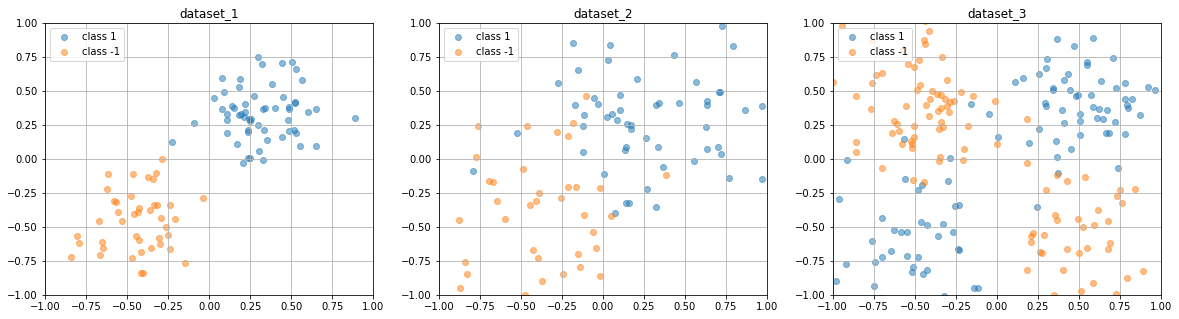

In [2]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
fig, ax = plt.subplots(1,3, figsize=(20, 5))
for i, (name, dataset) in enumerate(datasets.items()):
    
    plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax[i])
    ax[i].set_title(name)

## III- Kernel SVC 
### 1- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/(2\sigma^2))$. (The fastest solution does not use any for loop!)

In [3]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        diff = X[:,None,:] - Y[None,:,:]   ## tensors (N, M, d)
        norm = np.linalg.norm(diff, axis = 2)
        return np.exp(-norm**2 / (2*self.sigma**2))   ## Matrix of shape NxM
    
class Linear:
    def __init__(self):
        pass
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return X @ Y.T   ## Matrix of shape NxM


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [4]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        self.X = X

        # Lagrange dual problem
        def loss(alpha):
            #'''--------------dual loss ------------------ '''
            return 1./2 * np.linalg.multi_dot([alpha.T, self.kernel(X, X), alpha]) - alpha.T.dot(y)

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            # '''----------------partial derivative of the dual loss wrt alpha-----------------'''
            return self.kernel(X, X).dot(alpha) - y


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        # '''----------------function defining the equality constraint------------------'''
        fun_eq = lambda alpha: alpha.T.dot(np.ones(N))
        
        #'''----------------jacobian wrt alpha of the equality constraint------------------'''
        jac_eq = lambda alpha: np.ones(N)
        
        # '''---------------function defining the inequality constraint-------------------'''
        fun_ineq1 = lambda alpha: self.C*np.ones(N) - np.diag(1/y) @ alpha
        fun_ineq2 = lambda alpha: np.diag(1/y) @ alpha
        
        # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        jac_ineq1 = lambda alpha: - np.diag(1/y)
        jac_ineq2 = lambda alpha: np.diag(1/y)
        
        constraints = ({'type': 'eq', 'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 'fun': fun_ineq1, 'jac': jac_ineq1},
                       {'type': 'ineq', 'fun': fun_ineq2, 'jac': jac_ineq2})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes

        #'''------------------- A matrix with each row corresponding to a support vector ------------------'''
        supportIndices = np.asarray( (constraints[1]["fun"](self.alpha) > self.epsilon)&(constraints[2]["fun"](self.alpha) > self.epsilon) ).nonzero()
        self.support = X[supportIndices] 
        
        #''' -----------------offset of the classifier------------------ '''
        self.b = ( 1/y[supportIndices] - self.kernel(X, X).dot(self.alpha)[supportIndices] ).mean()
        
        # '''------------------------RKHS norm of the function f ------------------------------'''
        self.norm_f = np.linalg.multi_dot([self.alpha.T, self.kernel(X, X), self.alpha])


    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return self.alpha.T @ self.kernel(self.X, x)
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

### 2- Fitting the classifier

Run the code block below to fit the classifier and report its output.

Number of support vectors = 2
Number of support vectors = 3
Number of support vectors = 8


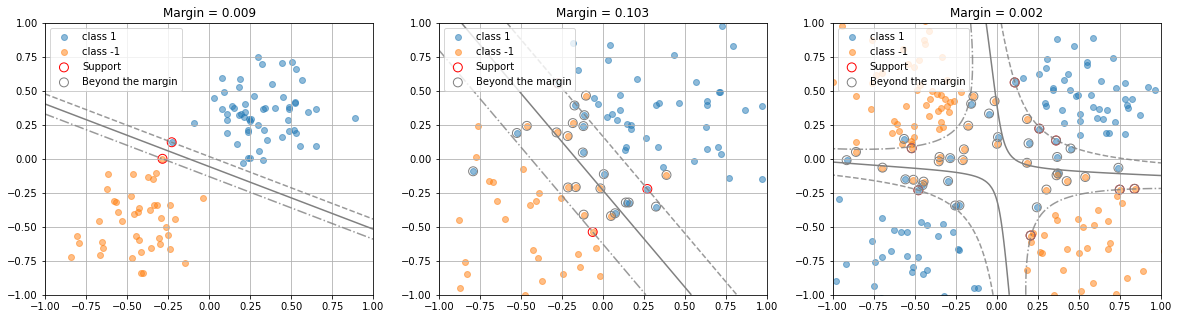

In [5]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
C = 10000.
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax = ax[0])

C = 10.
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax = ax[1])


sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax=ax[2])

# Kernel Regression

## Loading the data

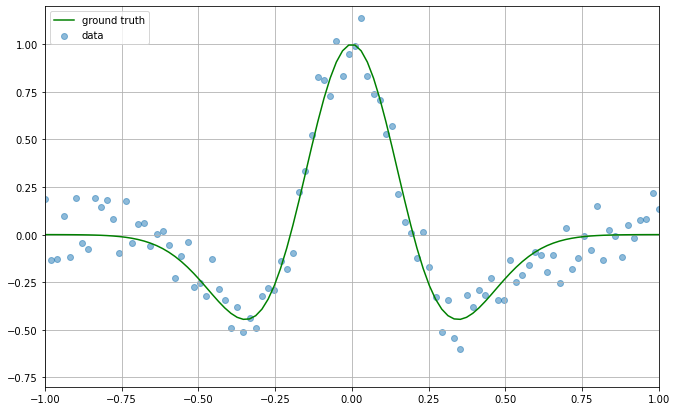

In [6]:
file = open('datasets/regression_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
train_set = datasets['dataset_1']['test']
plotRegression(train_set['x'], train_set['y'],Y_clean= train_set['y_clean'])

## Kernel  Support Vector Regression
### 1- Implementing the regressor
Implement the method 'fit' of the classes KernelSVR below to perform Kernel Support Vector Regression. 


In [7]:
class KernelSVR:
    
    def __init__(self, C, kernel, eta= 1e-2, epsilon = 1e-3):
        self.C = C                               
        self.kernel = kernel  
        self.alpha = None # Vector of size 2*N
        self.support = None
        self.eta = eta
        self.epsilon = epsilon
        self.eps = 0.
        self.type='svr'
        
    def fit(self, X, y):
        
        #### You might define here any variable needed for the rest of the code
        N = len(y)
        self.X = X
        self.N = N
        
        diff = lambda alpha: alpha[:N] - alpha[N:]
        summ = lambda alpha: alpha[:N] + alpha[N:]


        # Lagrange dual problem
        def loss(alpha):
            #'''--------------dual loss ------------------ '''
            return 1./2 * np.linalg.multi_dot([(alpha[:N]-alpha[N:]).T, self.kernel(X, X), (alpha[:N]-alpha[N:])]) + self.eta*(alpha[:N]+alpha[N:]).dot(np.ones(N)) - y.T.dot(alpha[:N]-alpha[N:])

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            grad_pos = self.kernel(X, X).dot(alpha[:N]) - self.kernel(X, X).dot(alpha[N:]) + self.eta - y
            grad_neg = self.kernel(X, X).dot(alpha[N:]) - self.kernel(X, X).dot(alpha[:N]) + self.eta + y
            return np.hstack([grad_pos, grad_neg])
            
        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        
        # '''----------------function defining the equality constraint------------------''' 
        fun_eq = lambda alpha: (alpha[:N]-alpha[N:]).T.dot(np.ones(N))
        
        #'''----------------jacobian wrt alpha of the equality constraint------------------'''
        jac_eq = lambda alpha: np.hstack([np.ones(N), -np.ones(N)])
        
        # '''---------------function defining the inequality constraint-------------------'''     
        fun_ineq1 = lambda alpha: self.C - alpha
        fun_ineq2 = lambda alpha: alpha
        
        # '''---------------jacobian wrt alpha of the inequality constraint-------------------'''
        jac_ineq1 = lambda alpha: - np.eye(alpha.shape[0])
        jac_ineq2 = lambda alpha: np.eye(alpha.shape[0])
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 'fun': fun_ineq1 , 'jac': jac_ineq1},
                       {'type': 'ineq', 'fun': fun_ineq2 , 'jac': jac_ineq2})
        
        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0= self.C*np.ones(2*N),
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints, 
                                   tol=1e-7)
        self.alpha = optRes.x

        ## Assign the required attributes
        
        #'''------------------- A matrix with each row corresponding to a support vector ------------------'''      
        supportIndices_pos = np.asarray( (constraints[1]["fun"](self.alpha[:N]) > self.epsilon)&(constraints[2]["fun"](self.alpha[:N]) > self.epsilon) ).nonzero()
        supportIndices_neg = np.asarray( (constraints[1]["fun"](self.alpha[N:]) > self.epsilon)&(constraints[2]["fun"](self.alpha[N:]) > self.epsilon) ).nonzero()
        supportIndices = np.union1d(supportIndices_pos[0], supportIndices_neg[0])
        self.support = np.hstack([X[supportIndices], y[supportIndices].reshape(-1,1)])
        
        #''' -----------------offset of the regressor ------------------ '''        
        margin_pos = ( y[supportIndices_pos] - (self.alpha[:N]-self.alpha[N:]).T.dot(self.kernel(X, X))[supportIndices_pos] - self.eta ).mean()
        margin_neg = ( self.eta + y[supportIndices_neg] - (self.alpha[:N]-self.alpha[N:]).T.dot(self.kernel(X, X))[supportIndices_neg] ).mean()
        self.b = 0.5*(margin_pos + margin_neg)

    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return (self.alpha[:self.N]-self.alpha[self.N:]).T @ self.kernel(self.X, x)
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return self.regression_function(X)+self.b
    

### 2- Fitting the regressor

Run the code block below to fit the regressor and report its output.

Number of support vectors = 18


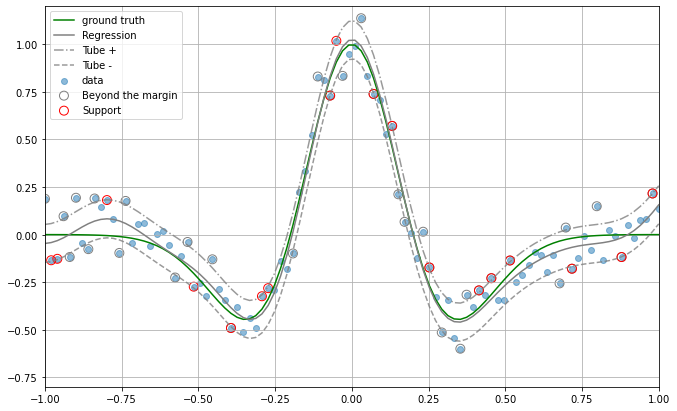

In [8]:
sigma = 0.2
C = 10.
kernel = RBF(sigma).kernel
model = KernelSVR(C,kernel, eta= .1, epsilon = 1e-6)
model.fit(train_set['x'].reshape(-1,1),train_set['y'])
plotRegression(train_set['x'], train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')